In [1]:
pip install deap

     |████████████████████████████████| 153kB 2.7MB/s 


In [2]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu, nc, nz, ngf):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 14 x 14
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Hyper parameters
params = {
    'input_size': 28,  # image size 1x64x64
    'batch_size': 64,  # batch size
    'pop_size': 100,   # population size
    'nc': 1,  # number of channels
    'nz': 100,  # size of z latent vector
    'ngf': 64,  # size of feature maps in generator
    'ndf': 32,  # size of feature maps in discriminator
    'num_epochs': 1000,  # number of epochs
    'lr': 0.0001,  # learning rate
    'beta1': 0.5,   # beta1 for adam optimizer
    'ngpu': 1,  # number of GPU
    'lambda_gp': 10,  # loss weight for gradient penalty
    'n_critic': 5,
}

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Generator(ngpu, nc, nz, ngf)
# 이 부분에서 체크포인트 위치 설정.
netG = Generator(params['ngpu'], params['nc'], params['nz'], params['ngf'])
netG.load_state_dict(torch.load(gdrive_root + '/checkpoints/netG_12500.pth', map_location=torch.device('cpu')))

# transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])
# data sets and data loader
train_data = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
train_data_loader = DataLoader(train_data, params['batch_size'], shuffle=False)
first_batch = train_data_loader.__iter__().__next__()  # first batch of MNIST data set : torch.Size([64x, 1, 28, 28])
print(first_batch[0][0].shape)  # torch.Size([1, 28, 28])
#imshow(first_batch[0][0])  # plot the image of first batch

0it [00:00, ?it/s]

9920512it [00:02, 3632858.25it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 56942.21it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 881793.27it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 21549.84it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
torch.Size([1, 28, 28])


In [0]:
# Input image for defense GAN
# For the test purpose, we will use MNIST data sample first.
# fgsm_image : torch.Size([1, 28, 28]). This is image x.
fgsm_image = first_batch[0][0]  # torch.Size([1, 28, 28]). This should be fgsm_image later on.

# evalFunc 에서 numpy 형태로 계산하려고 모양 수정 / 일단은 그냥 28, 28로 했는데 나중엔 일렬로 계산해도 될 듯.
x = fgsm_image.view(28,28).numpy()
#imshow(fgsm_image)

# individual은 numpy array
# numpy array 가 들어오면 -> tensor로 바꾸고, netG input 모양에 맞춰줌.
# netG의 output이 tensor 형태이므로, numpy로 바꿔서 계산.. (이부분 텐서 형태에서 계산으로 추후 수정하면 될 듯.)
def evalFunc(individual):
    individual = torch.from_numpy(individual).view(1, 100, 1, 1)
    return np.linalg.norm(netG(individual).view(28, 28).detach().numpy() - x, ord=2)**2,

# Initial population for GA
# initial_population : torch.Size([100, 100, 1, 1]), This has 100 latent vectors z (z is torch.Size([100, 1, 1])).
# for example, initial_population[0] is z_0, initial_population[1] is z_1, ..., initial_population[99] is z_99.
initial_population = torch.FloatTensor(params['pop_size'], params['nz'], 1, 1).normal_(0, 1)
#print(initial_population.shape)  # torch.Size([100, 100, 1, 1])


# 이 부분은 evalFunc 이 잘 작동하는지 확인하는 부분입니당.
# z 가 길이 100짜리 1차원 numpy array 라고 가정하고(GA 에서 기본 individual 형태) evalFunc에 넣은뒤, 출력
# z = torch.FloatTensor(1, params['nz'], 1, 1).normal_(0, 1)
# z = z.view(100).numpy()
# print(evalFunc(z))

# initial_population를 numpy로 타입 맞춰주기.
initial_population = initial_population.view(100, 100).numpy()

def initIndividual(icls, content):
  return icls(content)

def initPopulation(pcls, ind_init):
  return pcls(ind_init(c) for c in initial_population)

In [0]:
import random
from deap import creator, base, tools, algorithms

# TOCHECK:  will we use algorithm modules?

'''
Fitness : single optimization, minimize ||G(z) - x||^2_2
'''
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin) # minimizing the fitness value

toolbox = base.Toolbox()

'''
[HYPERPARAMETERS]
List of Floats: individuals composed of 'IND_SIZE' floating point numbers
IND_SIZE: z의 dimension으로 보면 될듯
POPULATION
CXPB: probability of crossover
MUTPB: probability of mutation
'''
IND_SIZE = 100
POPULATION = 100
CXPB, MUTPB = 0.2, 0.2
GENERATIONS = 100

toolbox.register("attr_float", random.random)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)
toolbox.register("individual", initIndividual, creator.Individual)
toolbox.register("population", initPopulation, list, toolbox.individual)

In [0]:
def cxTwoPointCopy(ind1, ind2):
    """Execute a two points crossover with copy on the input individuals. The
    copy is required because the slicing in numpy returns a view of the data,
    which leads to a self overwritting in the swap operation. It prevents
    ::
    
        >>> import numpy
        >>> a = numpy.array((1,2,3,4))
        >>> b = numpy.array((5,6,7,8))
        >>> a[1:3], b[1:3] = b[1:3], a[1:3]
        >>> print(a)
        [1 6 7 4]
        >>> print(b)
        [5 6 7 8]
    """
    size = len(ind1)
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2].copy(), ind1[cxpoint1:cxpoint2].copy()
        
    return ind1, ind2

In [0]:
'''
Evaluation Function: ||G(z) - x||^2_2 <- use 'np.linalg.norm( , ord=2)**2'
'''
# TODO : need to change mate, mutate, select operator
# can check in here : https://deap.readthedocs.io/en/master/api/tools.html
toolbox.register("evaluate", evalFunc)
toolbox.register("mate", cxTwoPointCopy)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [0]:
def main():
    random.seed(777)

    # pop = toolbox.population(n=POPULATION)
    pop = toolbox.population()
    
    print("Start of evolution")

    # Evaluate the entire population
    # print(fitnesses) -> [(84,), (105,), (96,), (104,), (94,),  ... ] 이런식으로 저장됨.
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while min(fits) > 10 and g < GENERATIONS:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)
        
        # Select the next generation individuals
        # len(pop) -> 50, len(pop[0]) -> 5
        offspring = toolbox.select(pop, len(pop))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        '''
        they modify those individuals within the toolbox container 
        and we do not need to reassign their results.
        '''
        # TODO: want p_new1 = p_m - beta(p_m - p_d), p_new2 = p_m + beta(p_m - p_d)
        # want to customize mutation method... there is no proper mutation operator in deap.tools...

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)


    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    print(best_ind.fitness.values)
    return best_ind
# main()

Start of evolution
-- Generation 1 --
  Min 63.412510144468115
  Max 215.61453505455574
  Avg 132.70238100301552
  Std 27.250620733658643
-- Generation 2 --
  Min 63.412510144468115
  Max 169.05182663511732
  Avg 111.77037914782228
  Std 25.40015849665994
-- Generation 3 --
  Min 61.780786453602786
  Max 184.14623762144765
  Avg 93.78120856556599
  Std 26.83037261498026
-- Generation 4 --
  Min 58.44023592464714
  Max 113.80883322778482
  Avg 73.08886922409526
  Std 14.111679140611788
-- Generation 5 --
  Min 58.44023592464714
  Max 135.15783173969248
  Avg 66.73162264602772
  Std 8.753278057874512
-- Generation 6 --
  Min 58.44023592464714
  Max 104.78549833631041
  Avg 64.29723542705324
  Std 6.5454431810383165
-- Generation 7 --
  Min 56.211704575440535
  Max 91.77892014669487
  Avg 63.33888144159836
  Std 6.817360021221939
-- Generation 8 --
  Min 52.11640306993672
  Max 98.16538349731127
  Avg 62.03126005800404
  Std 6.222405508844501
-- Generation 9 --
  Min 52.11640306993672
  M

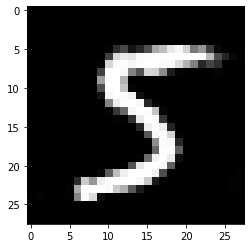

In [11]:
# For each generation, select the latent vector z* that minimizes fitness, and do the following.
# z = torch.FloatTensor(1, params['nz'], 1, 1).normal_(0, 1)  # torch.Size([100, 1, 1]). This should be z* later on.
output = np.array(main())

z = torch.from_numpy(output).view(1, 100, 1, 1)

gen_image = netG(z)  # torch.Size([1, 28, 28]). This is the generated image that we want to see for each generation.
# Because gen_image should step closer to fgsm_image x for each generation.
print("the shape of generated image : " + str(gen_image.shape))
imshow(gen_image.detach())  # plot the image of generated image

# After GA, give generated image as input to each classifier (use gen_image)